<a href="https://colab.research.google.com/github/caoTayTang/image_super_resolution_traditional_cv/blob/main/notebooks/experiments_ml_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import sys
import os
import cv2
import numpy as np
sys.path.append(os.path.abspath('..'))
from src import utils
from src import ml_patch
import matplotlib.pyplot as plt


In [11]:
# Classify images into degraded_lr and input_hr folders
base_dir = '../data/jbhuang0604 SelfExSR master data/BSD100'
output_dir = ['../data/degraded_lr', '../data/input_hr']
utils.img_classify(base_dir, output_dir)

SRF_2 done: 200 images processed.
SRF_3 done: 200 images processed.
SRF_4 done: 200 images processed.


In [12]:
# Chia patches from degraded_lr and input_hr folders và lưu giá trị YIQ sau khi normalize của nó
base_dir = ['../data/degraded_lr', '../data/input_hr']
output_dir = '../data/YIQ_patches'
ml_patch.process_all_patches(base_dir, output_dir, patch_size=5, overlap=0.5)


Extracted 920400 LR patches, 920400 HR patches, 920400 LR feature patches, 920400 LR_Y_means and 920400 HR_centered_patches from 100 image pairs.
Saved normalized YIQ LR/HR patches for scale x2 to ../data/YIQ_patches
Extracted 405600 LR patches, 405600 HR patches, 405600 LR feature patches, 405600 LR_Y_means and 405600 HR_centered_patches from 100 image pairs.
Saved normalized YIQ LR/HR patches for scale x3 to ../data/YIQ_patches
Extracted 220400 LR patches, 220400 HR patches, 220400 LR feature patches, 220400 LR_Y_means and 220400 HR_centered_patches from 100 image pairs.
Saved normalized YIQ LR/HR patches for scale x4 to ../data/YIQ_patches


In [13]:
# tách tập target img thành 2 folder lr và hr
target_dir = '../data/jbhuang0604 SelfExSR master data/Set5'
target_output_dir = ['../data/target_lr', '../data/target_hr']
utils.img_classify(target_dir, target_output_dir)

SRF_2 done: 10 images processed.
SRF_3 done: 10 images processed.
SRF_4 done: 10 images processed.


In [30]:
# chia patch cho ảnh target lr, hr k xài tới
lr_img_path = '../data/target_lr/LR_x3/img_002_SRF_3_LR.png'
LR_patches, target_LR_features_patches, target_lr_y_mean = ml_patch.extract_patches_per_image(lr_img_path, hr_img_path=None, scale=2, patch_size=5, overlap=0.5)

In [31]:
LR_features_patches = np.load('../data/YIQ_patches/LR_features_patches_x3.npy')
HR_centered_patches = np.load('../data/YIQ_patches/HR_centered_patches_x3.npy')

predicted_HR_patches = []

knn_model, feat_vectors = ml_patch.build_knn_idx(LR_features_patches, k=5)

"""
1. Duyệt qua từng patch của ảnh target LR
2. Với mỗi patch, tìm k patch lân cận gần nhất trong tập training
3. Tính trọng số w dựa trên patch LR mục tiêu và các patch lân cận
4. Áp dụng trọng số w vào các patch HR tương ứng để dự đoán patch HR
5. Lưu patch HR đã dự đoán vào danh sách predicted_HR_patches
"""
for i, patch in enumerate(target_LR_features_patches):
    print(f'Processing patch {i+1}/{len(target_LR_features_patches)}', end='\r')
    distances, indices = ml_patch.query_knn(knn_model, feat_vectors=feat_vectors, query_feat=patch, k=5)
    neighbor_vecs = feat_vectors[indices]
    w = ml_patch.compute_weights(patch, neighbor_vecs, epsilon=1e-6)
    neighbor_hr_patches = HR_centered_patches[indices]
    lr_y_mean = target_lr_y_mean[i]
    predicted_HR_patch = ml_patch.map_hr_patches(neighbor_hr_patches, w, lr_y_mean)
    predicted_HR_patches.append(predicted_HR_patch)




In [33]:
"""
Tính lại ảnh HR từ các patch HR đã dự đoán, do extract tất cả các patch thành 1 file riêng rồi nên phải
tính lại vị trí của patch trong ảnh, sau đó cộng dồn các patch vào đúng vị trí trong ảnh HR đã dự đoán
và chia cho số patch chồng lên nhau (weight_mask) để xử lí overlapping
"""

lr_img = cv2.imread(lr_img_path, cv2.IMREAD_COLOR)
H_lr, W_lr = lr_img.shape[:2]
scale = 3
H_hr = H_lr * scale
W_hr = W_lr * scale

predicted_HR_img = np.zeros((H_hr, W_hr), dtype=np.float32)  # kênh Y
weight_mask = np.zeros((H_hr, W_hr), dtype=np.float32)       # để normalize overlapping, xài mean thôi

patch_size = 5
overlap = 0.5
step = int(patch_size*(1-overlap))

patch_idx = 0
for i in range(0, H_lr - patch_size + 1, step):
    for j in range(0, W_lr - patch_size + 1, step):
        i_hr, j_hr = i*scale, j*scale
        predicted_HR_img[i_hr:i_hr+patch_size*scale, j_hr:j_hr+patch_size*scale] += predicted_HR_patches[patch_idx]
        weight_mask[i_hr:i_hr+patch_size*scale, j_hr:j_hr+patch_size*scale] += 1.0
        patch_idx += 1

# ở biên cuối nếu ảnh không chia hết cho patch thì sẽ thiếu patch, báo invalid divide nên ở rìa bị mất vài pixel,
# kệ chắc k sao
predicted_HR_img /= weight_mask
predicted_HR_img = ml_patch.reconstruct_hr_rgb(predicted_HR_img, lr_img_path, scale=scale)

C:\Users\Duong\AppData\Local\Temp\ipykernel_7332\2375998686.py:30: RuntimeWarning: invalid value encountered in divide
  predicted_HR_img /= weight_mask
d:\bku_docs\251\CV\BTL\image_super_resolution_traditional_cv\src\ml_patch.py:341: RuntimeWarning: invalid value encountered in cast
  predicted_HR_rgb_uint8 = (predicted_HR_rgb*255).astype(np.uint8)


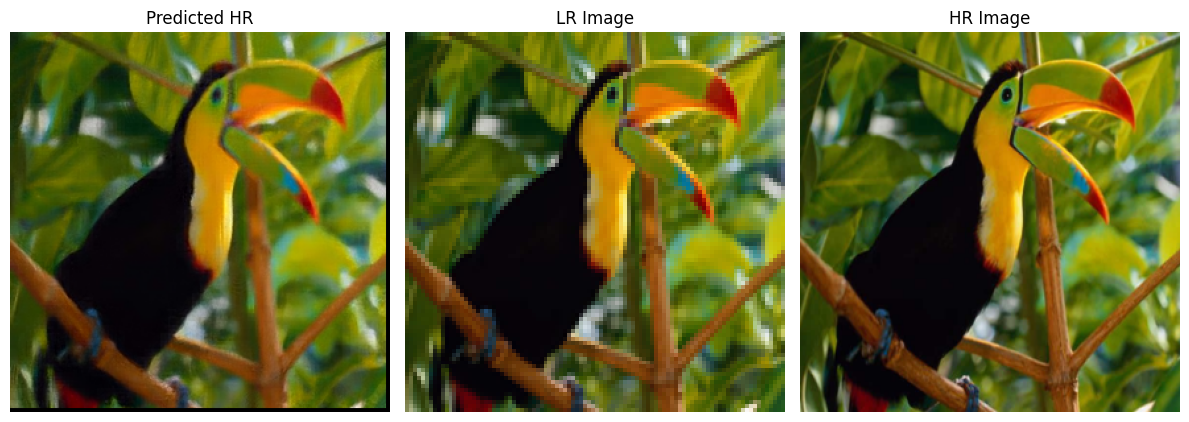

In [34]:
# đọc lr image
lr_img = cv2.imread(lr_img_path, cv2.IMREAD_COLOR)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

# expected hr image
hr_img = cv2.imread('../data/target_hr/HR_x3/img_002_SRF_3_HR.png', cv2.IMREAD_COLOR)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)

# tạo figure với 1 hàng, 2 cột
fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # 1 row, 2 columns

# ảnh Predicted HR
axes[0].imshow(predicted_HR_img)
axes[0].set_title('Predicted HR')
axes[0].axis('off')

# ảnh LR
axes[1].imshow(lr_img)
axes[1].set_title('LR Image')
axes[1].axis('off')

# ảnh HR
axes[2].imshow(hr_img)
axes[2].set_title('HR Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()